# VAE training and processing

In [ ]:
import os
import math
import string
import numpy as np
import pandas as pd
import heapq
import pickle
import scipy.io as sio
import random

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tensorflow as tf
import tf_keras
import keras
import tensorflow.keras.backend as K

from scipy.stats import dirichlet
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

os.environ["TF_USE_LEGACY_KERAS"]= '1' # Use legacy keras for compatibility

In [2]:
ANTENNAS = 1
antenna = 0  # if ANTENNAS==1, this value selects the antenna ID (from 0 to 3)

BATCH_SIZE = 25
latent_dim = 2
num_activities = 5
folder_name = f'models/single_antenna_{antenna}'

base_directory = './models'
os.makedirs(base_directory, exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./results_csv', exist_ok=True)
os.makedirs('./results_graphs', exist_ok=True)

saveGraph = False

In [3]:
random_state = 42
random.seed(random_state)
np.random.seed(random_state) # predictable random numbers, for demonstration only
tf.random.set_seed(random_state) # reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1' # make operations deterministic
os.environ['PYTHONHASHSEED'] = str(random_state) # reproducibility

# computes golden ratio for figures
def goldenrect(h):
    return (h * 1.618, h)

def summary_clf(y_test, predicted, y_score, _labels = None):
    print(classification_report(y_test, predicted, labels= _labels))

## CSI data generator

In [4]:
class CsiData(tf_keras.utils.Sequence):
    def __init__(self, csi, labels, indices, batch_size=25, window_size=450, antennas=1):
        self.csi = csi
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size
        self.window_size = window_size
        self.antennas = antennas

    def __len__(self):
        return int(np.ceil(self.indices.shape[-1] / float(self.batch_size)))

    def __getitem__(self, batch_idx):
        first_idx = batch_idx * self.batch_size
        last_idx = (batch_idx + 1) * self.batch_size

        #print(f'first_idx: {first_idx}, last_idx: {last_idx}')
        
        data_batch = [self.csi[x:x + self.window_size, ...] for x in range(first_idx, last_idx)]
        labels_batch = np.transpose([self.labels[first_idx:last_idx]])

        data_batch = tf.convert_to_tensor(data_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)

        if self.antennas == 1:
            data_batch = tf.expand_dims(data_batch, 3)
            labels_batch = tf.expand_dims(labels_batch, 2)

        return data_batch, labels_batch

In [ ]:
"""def load_split_train_test_CSI_data(file_list, num_samples=12000, window_size=450, batch_size=25, antennas=1, random_state=42, verbose=False):
    csi_per_sec = 150
    windows_per_activity = 5
    train_seconds = 9
    test_seconds = 4
    validation_seconds = 3

    if antennas == 1:
        train_data = tf.zeros([0, 2048], dtype=tf.float32)
        test_data = tf.zeros([0, 2048], dtype=tf.float32)
    else:
        train_data = tf.zeros([0, 2048, antennas], dtype=tf.float32)
        test_data = tf.zeros([0, 2048, antennas], dtype=tf.float32)

    train_labels = tf.zeros([0], dtype=tf.int32)
    test_labels = tf.zeros([0], dtype=tf.int32)
    train_indices = tf.zeros([0], dtype=tf.int32)
    test_indices = tf.zeros([0], dtype=tf.int32)

    validation_data = tf.zeros([0, 2048], dtype=tf.float32)
    validation_labels = tf.zeros([0], dtype=tf.int32)
    validation_indices = tf.zeros([0], dtype=tf.int32)

    for file in file_list:
        if verbose: print(f"\n*************** activity {file_list.index(file)} ***************")
        # Load CSI data from MATLAB file
        mat = sio.loadmat(file)      # WARNING This code does not handle exceptions for simplicity...
        data = np.array(mat['csi'])  # ...exceptions would require keeping track of indices
        if antennas == 1:
            data = data[range(num_samples), ..., int(antenna)]
        data = np.round(np.abs(data))
        train_index_offset = train_data.shape[0]
        validation_index_offset = validation_data.shape[0]
        test_index_offset = test_data.shape[0]
        activity_label = file_list.index(file)  # Labels depend on file index 

        n_samples_activity = data.shape[0]//windows_per_activity

        tmp_train_data = np.zeros((0, 2048))
        tmp_test_data = np.zeros((0, 2048))
        tmp_validation_data = np.zeros((0, 2048))
        
        for iter in range(windows_per_activity):
            if verbose: print(f"\n-------- {iter} ---------")
            start_train_idx = n_samples_activity * iter
            end_train_idx = start_train_idx + csi_per_sec * train_seconds
            if verbose: print(f"train idx {start_train_idx} to {end_train_idx}")
            tmp_train_data = np.append(tmp_train_data, data[start_train_idx : end_train_idx], axis=0)
            
            if verbose: print("train shape", tmp_train_data.shape)

            #Insert here the validation data (between train and ignore)
            start_validation_idx = end_train_idx
            end_validation_idx = start_validation_idx + csi_per_sec * validation_seconds
            if verbose: print(f"validation idx {start_validation_idx} to {end_validation_idx}")
            tmp_validation_data = np.append(tmp_validation_data, data[start_validation_idx : end_validation_idx], axis=0)

            if verbose: print("validation shape", tmp_validation_data.shape)

            start_test_idx = end_validation_idx
            end_test_idx = start_test_idx + csi_per_sec * test_seconds
            if verbose: print(f"test idx {start_test_idx} to {end_test_idx}")
            #tmp_test_data = np.append(tmp_test_data, data[start_test_idx : end_test_idx], axis=0)
            tmp_test_data = np.append(tmp_test_data, data[start_test_idx : n_samples_activity * (iter+1)], axis=0)
            
            if verbose: print("test shape", tmp_test_data.shape)

        train_num_samples = tmp_train_data.shape[0]
        tmp_train_data = tf.convert_to_tensor(tmp_train_data, dtype=tf.float32)
        tmp_train_labels = tf.convert_to_tensor(activity_label * np.ones(train_num_samples - window_size), dtype=tf.int32)
        tmp_train_indices = tf.convert_to_tensor(tf.range(train_index_offset, train_index_offset + train_num_samples - window_size), dtype=tf.int32)

        validation_num_samples = tmp_validation_data.shape[0]
        tmp_validation_data = tf.convert_to_tensor(tmp_validation_data, dtype=tf.float32)
        tmp_validation_labels = tf.convert_to_tensor(activity_label * np.ones(validation_num_samples - window_size), dtype=tf.int32)
        tmp_validation_indices = tf.convert_to_tensor(tf.range(validation_index_offset, validation_index_offset + validation_num_samples - window_size), dtype=tf.int32)

        test_num_samples = tmp_test_data.shape[0]
        tmp_test_data = tf.convert_to_tensor(tmp_test_data, dtype=tf.float32)
        tmp_test_labels = tf.convert_to_tensor(activity_label * np.ones(test_num_samples - window_size), dtype=tf.int32)
        tmp_test_indices = tf.convert_to_tensor(tf.range(test_index_offset, test_index_offset + test_num_samples - window_size), dtype=tf.int32)

        train_data = tf.concat([train_data, tmp_train_data], axis=0)
        train_labels = tf.concat([train_labels, tmp_train_labels], axis=0)
        train_indices = tf.concat([train_indices, tmp_train_indices], axis=0)

        validation_data = tf.concat([validation_data, tmp_validation_data], axis=0)
        validation_labels = tf.concat([validation_labels, tmp_validation_labels], axis=0)
        validation_indices = tf.concat([validation_indices, tmp_validation_indices], axis=0)

        test_data = tf.concat([test_data, tmp_test_data], axis=0)
        test_labels = tf.concat([test_labels, tmp_test_labels], axis=0)
        test_indices = tf.concat([test_indices, tmp_test_indices], axis=0)

        if verbose: print(train_data.shape, train_labels.shape)
        if verbose: print(validation_data.shape, validation_labels.shape)
        if verbose: print(test_data.shape, test_labels.shape)

    # Normalize the CSI dataset
    if antennas == 1:
        train_data = tf.math.divide(train_data, tf.math.reduce_max(train_data, axis=(0, 1)))
        validation_data = tf.math.divide(validation_data, tf.math.reduce_max(validation_data, axis=(0, 1)))
        test_data = tf.math.divide(test_data, tf.math.reduce_max(test_data, axis=(0, 1)))
    else:
        train_data = tf.math.divide(train_data, tf.math.reduce_max(train_data, axis=(0, 1, 2)))
        validation_data = tf.math.divide(validation_data, tf.math.reduce_max(validation_data, axis=(0, 1, 2)))
        test_data = tf.math.divide(test_data, tf.math.reduce_max(test_data, axis=(0, 1, 2)))

    train_data = CsiData(train_data, train_labels, train_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)
    validation_data = CsiData(validation_data, validation_labels, validation_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)
    test_data = CsiData(test_data, test_labels, test_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)

    return train_data, validation_data, test_data
    """

In [6]:
def load_split_train_test_CSI_data(file_list, num_samples=12000, window_size=450, batch_size=25, antennas=1, random_state=42, verbose=False):
    csi_per_sec = 150
    windows_per_activity = 5
    train_seconds = 9
    test_seconds = 1
    ignore_seconds = 3

    if antennas == 1:
        train_data = tf.zeros([0, 2048], dtype=tf.float32)
        test_data = tf.zeros([0, 2048], dtype=tf.float32)
    else:
        train_data = tf.zeros([0, 2048, antennas], dtype=tf.float32)
        test_data = tf.zeros([0, 2048, antennas], dtype=tf.float32)

    train_labels = tf.zeros([0], dtype=tf.int32)
    test_labels = tf.zeros([0], dtype=tf.int32)
    train_indices = tf.zeros([0], dtype=tf.int32)
    test_indices = tf.zeros([0], dtype=tf.int32)

    for file in file_list:
        if verbose: print(f"\n*************** activity {file_list.index(file)} ***************")
        # Load CSI data from MATLAB file
        mat = sio.loadmat(file)      # WARNING This code does not handle exceptions for simplicity...
        data = np.array(mat['csi'])  # ...exceptions would require keeping track of indices
        if antennas == 1:
            data = data[range(num_samples), ..., int(antenna)]
        data = np.round(np.abs(data))
        train_index_offset = train_data.shape[0]
        test_index_offset = test_data.shape[0]
        activity_label = file_list.index(file)  # Labels depend on file index 

        n_samples_activity = data.shape[0]//windows_per_activity

        tmp_train_data = np.zeros((0, 2048))
        tmp_test_data = np.zeros((0, 2048))

        for iter in range(windows_per_activity):
            if verbose: print(f"\n-------- {iter} ---------")
            start_train_idx = 0 + (n_samples_activity) * iter
            end_train_idx = start_train_idx + csi_per_sec * train_seconds
            if verbose: print(f"train idx {start_train_idx} to {end_train_idx}")
            tmp_train_data = np.append(tmp_train_data, data[start_train_idx : end_train_idx], axis=0)
            
            if verbose: print("train shape", tmp_train_data.shape)

            start_test_idx = end_train_idx + csi_per_sec * test_seconds
            end_test_idx =  start_test_idx + csi_per_sec * ignore_seconds
            if verbose: print(f"ignoring idx from {end_train_idx} to {start_test_idx}")

            if verbose: print(f"test idx {start_test_idx} to {end_test_idx}")
            tmp_test_data = np.append(tmp_test_data, data[start_test_idx : end_test_idx], axis=0)
            
            if verbose: print("test shape", tmp_test_data.shape)

        train_num_samples = tmp_train_data.shape[0]
        tmp_train_data = tf.convert_to_tensor(tmp_train_data, dtype=tf.float32)
        tmp_train_labels = tf.convert_to_tensor(activity_label * np.ones(train_num_samples - window_size), dtype=tf.int32)
        tmp_train_indices = tf.convert_to_tensor(tf.range(train_index_offset, train_index_offset + train_num_samples - window_size), dtype=tf.int32)

        test_num_samples = tmp_test_data.shape[0]
        tmp_test_data = tf.convert_to_tensor(tmp_test_data, dtype=tf.float32)
        tmp_test_labels = tf.convert_to_tensor(activity_label * np.ones(test_num_samples - window_size), dtype=tf.int32)
        tmp_test_indices = tf.convert_to_tensor(tf.range(test_index_offset, test_index_offset + test_num_samples - window_size), dtype=tf.int32)

        train_data = tf.concat([train_data, tmp_train_data], axis=0)
        train_labels = tf.concat([train_labels, tmp_train_labels], axis=0)
        train_indices = tf.concat([train_indices, tmp_train_indices], axis=0)

        test_data = tf.concat([test_data, tmp_test_data], axis=0)
        test_labels = tf.concat([test_labels, tmp_test_labels], axis=0)
        test_indices = tf.concat([test_indices, tmp_test_indices], axis=0)

        if verbose: print(train_data.shape, train_labels.shape)
        if verbose: print(test_data.shape, test_labels.shape)

    # Normalize the CSI dataset
    if antennas == 1:
        train_data = tf.math.divide(train_data, tf.math.reduce_max(train_data, axis=(0, 1)))
        test_data = tf.math.divide(test_data, tf.math.reduce_max(test_data, axis=(0, 1)))
    else:
        train_data = tf.math.divide(train_data, tf.math.reduce_max(train_data, axis=(0, 1, 2)))
        test_data = tf.math.divide(test_data, tf.math.reduce_max(test_data, axis=(0, 1, 2)))

    train_data = CsiData(train_data, train_labels, train_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)
    test_data = CsiData(test_data, test_labels, test_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)

    return train_data, test_data

## Variational Auto-Encoder

In [7]:
class Sampling(tf_keras.layers.Layer):
    """Takes a couple (z_mean, z_log_var) to draw a sample z from the latent space."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_csi_encoder(input_shape, latent_dim):
    encoder_inputs = tf_keras.Input(shape=input_shape)
    x = tf_keras.layers.Conv2D(32, (5, 8), activation='relu', strides=(5, 8), padding='valid')(encoder_inputs)
    x = tf_keras.layers.Conv2D(32, (5, 8), activation='relu', strides=(5, 8), padding='valid')(x)
    x = tf_keras.layers.Conv2D(32, (2, 4), activation='relu', strides=(2, 4), padding='valid')(x)
    x = tf_keras.layers.Flatten()(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)

    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    return tf_keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')


def create_csi_decoder(input_shape, latent_dim, out_filter):
    decoder_inputs = tf_keras.Input(shape=(latent_dim,))
    x = tf_keras.layers.Dense(math.prod(input_shape), activation='relu')(decoder_inputs)
    x = tf_keras.layers.Reshape(input_shape)(x)
    x = tf_keras.layers.Conv2DTranspose(32, (2, 4), activation='relu', strides=(2, 4), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    decoder_outputs = tf_keras.layers.Conv2DTranspose(out_filter, out_filter, activation='sigmoid', padding='same')(x)

    return tf_keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [8]:
class VAE(tf_keras.Model):
    def __init__(self, enc_input_shape=(450, 2048, 1), dec_input_shape=(9, 8, 32), latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = create_csi_encoder(enc_input_shape, latent_dim)
        self.decoder = create_csi_decoder(dec_input_shape, latent_dim, enc_input_shape[-1])
        self.total_loss_tracker = tf_keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf_keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf_keras.metrics.Mean(name='kl_loss')

        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf_keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        pass


In [9]:
def apply_vae_encoder(vae, source):
    #Use the VAE to process CSI data
    z_data = np.zeros([0, 4])
    z_labels = np.zeros([0])

    for (data, labels) in source:
        labels = tf.squeeze(labels)
        z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
        z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
        z_data = np.concatenate([z_data, z_tmp], axis=0)
        z_labels = np.concatenate([z_labels, labels.numpy().ravel()], axis=0)
        
    return z_data, z_labels

In [10]:
checkpoint_path = f'./{folder_name}/' + 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = tf_keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stopping_cb = tf_keras.callbacks.EarlyStopping(monitor='loss', patience=10)
csv_logger_cb = tf_keras.callbacks.CSVLogger(f'./{folder_name}/model_history_log.csv', append=True)

## Data Processing

### PCA Compression

In [11]:
def find_n_components(data, target, directory=base_directory, saveGraph=False, plotGraph=True):
    os.makedirs(directory, exist_ok=True)
    #Apply PCA
    pca = PCA()
    pca.fit(data)

    var_cumulative = np.cumsum(pca.explained_variance_ratio_)*100

    #finds PCs that explain 95% of the variance
    num_components = np.argmax(var_cumulative > target) + 1
    print(f"Number of components explaining {target}% variance: "+ str(num_components))

    if plotGraph:
        plt.figure(figsize=(10, 5))
        plt.title('Cumulative Explained Variance explained by the components')
        plt.ylabel('Cumulative Explained variance')
        plt.xlabel('Principal components')
        plt.axvline(x=num_components, color="r", linestyle="--")
        plt.axhline(y=target, color="r", linestyle="--")
        plt.plot(range(1, pca.n_components_ + 1), var_cumulative, marker='o', linestyle='--')
        plt.grid()
        if (saveGraph):
            graph_path = os.path.join(directory, 'var_cumulative_x_component.png')
            plt.savefig(graph_path)
            print("Graph saved in: ", graph_path)
        plt.show()

    return num_components

def analyze_PCA(data, n_components, directory=base_directory, saveGraph=False, plotGraph=True):
    os.makedirs(directory, exist_ok=True)
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)

    reduced_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i}' for i in range(n_components)])

    #Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    #Cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Final Cumulative Explained Variance:", cumulative_explained_variance[-1])

    if (plotGraph):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        if (saveGraph):
            graph_path = os.path.join(directory, 'cumulative_explained_variance.png')
            plt.savefig(graph_path)
            print("Graph saved in: ", graph_path)
        plt.show()
    
    return reduced_df, pca

def reconstruct_data(df, pca, columns):
    df_reconstructed = pca.inverse_transform(df.values)
    df_reconstructed = pd.DataFrame(df_reconstructed, columns=columns)    
    return df_reconstructed

### Quantization

In [12]:
def lloyd_max_quantization(data, num_levels=16, max_iter=100, delta=1e-6):
    min_val = np.min(data)
    max_val = np.max(data)
    clusters = np.linspace(min_val, max_val, num_levels) #Uniformly spaced 

    for _ in range(max_iter):
        thresholds = (clusters[:-1] + clusters[1:]) / 2 #Defines intervals of clusters
        indices = np.digitize(data, thresholds) #Assign each data point to a cluster
        
        new_clusters = np.array([data[indices == i].mean() for i in range(num_levels)]) #Update clusters to better represent the data
        
        empty_clusters = np.isnan(new_clusters) #Restore previous cluster if empty
        new_clusters[empty_clusters] = clusters[empty_clusters] 

        #stop if changes between iterations are small
        if np.max(np.abs(new_clusters - clusters)) < delta:
            break

        clusters = new_clusters

    #Quantize the data based on the final clusters
    quantized_data = clusters[indices]

    return quantized_data, clusters, thresholds

def dequantize_lloyd_max(quantized_data, clusters, thresholds):
    indices = np.digitize(quantized_data, thresholds, right=True)
    return clusters[indices]

def apply_quantization(reduced_df, lvls):
    df_quantized = reduced_df.apply(lambda col: lloyd_max_quantization(col.values, num_levels=lvls)[0])
    return df_quantized

### Huffman 

In [13]:
class Node: 
    def __init__(self, value=None, frequency=0, left=None, right=None):
        self.value = value
        self.frequency = frequency
        self.left = left
        self.right = right

    def __lt__(self, other): #redefined "less than" operator for heapq
        return self.frequency < other.frequency

def build_tree(data):
    heap = [Node(value, frequency) for value, frequency in data.items()]  #Init heap
    heapq.heapify(heap)

    while len(heap) > 1:  #pop two smallest nodes, merge them and push the merged node back
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(frequency=left.frequency + right.frequency, left=left, right=right)
        heapq.heappush(heap, merged) 

    return heap[0] #root

def generate_codes(node, code="", huffman_codes=None):
    if huffman_codes is None: 
        huffman_codes = {}

    if node.value is not None: #leaf node case
        huffman_codes[node.value] = code
        return
    else:
        generate_codes(node.left, code + "0", huffman_codes)
        generate_codes(node.right, code + "1", huffman_codes)
    return huffman_codes

def encode_huffman(data, huffman_codes):
    emptyStr = ""
    return emptyStr.join([huffman_codes[val] for val in data]) 

def decode_huffman(encoded_data, huffman_codes):
    decoded_data = []
    code = ""
    for bit in encoded_data: #traverse the encoded data and searches for the code
        code += bit
        for key, value in huffman_codes.items():
            if value == code: #If found, append the corresponding value to the decoded data, otherwise add another bit to the code
                decoded_data.append(key)
                code = ""
                break
                
    return decoded_data

def apply_huffman_encode_per_feature(data):
    encoded_df = pd.DataFrame()
    huffman_codes = {}

    for col in data.columns:
        freq_per_data = Counter(data[col]) 
        root = build_tree(freq_per_data)
        code = generate_codes(root)
        encoded_df[col] = data[col].apply(lambda x: encode_huffman([x], code))
        huffman_codes[col] = code
        
    return encoded_df, huffman_codes

def apply_huffman_decode_per_feature(encoded_data, huffman_codes):
    decoded_df = pd.DataFrame()

    for col in encoded_data.columns:
        decoded_df[col] = decode_huffman(''.join(encoded_data[col]), huffman_codes[col])
    return decoded_df

def apply_encoding(df_quantized):
    encoded_df, huffman_codes = apply_huffman_encode_per_feature(df_quantized)
    return encoded_df, huffman_codes

def apply_decoding(encoded_df, huffman_codes):
    decoded_df = apply_huffman_decode_per_feature(encoded_df.iloc[:, 2:-1], huffman_codes)
    return decoded_df

### Metrics

In [14]:
def bits_needed(source, num_lvls=-1):
    data = source.copy()
    window_size = 450
    num_features = len(data.columns)
    bits_needed_unique = {}
    avg_bits_needed = {}
    bits_needed_window = {}
    total_bits_needed_dataset = 0

    for index in range(0, len(data), window_size):
        data_window = data.iloc[index : index + window_size] 
        for col in data_window.columns:
            num_symbols = len(data_window[col].unique())
            if num_lvls > 0:
                bits_needed_unique[col] = np.ceil(np.log2(num_lvls)).astype(int)
            else:
                bits_needed_unique[col] = np.ceil(np.log2(num_symbols)).astype(int)
                #print(f"Column: {col}, Bits needed: {bits_needed_unique[col]} bits (num levels: {num_lvls})")
                
        avg_bits_needed[index] = np.mean(list(bits_needed_unique.values())).round(2)
        bits_needed_window[index] = sum(bits_needed_unique.values())
        total_bits_needed_dataset += sum(bits_needed_unique.values())

    bits_needed = np.mean(list(avg_bits_needed.values())).round(2)
    bits_needed_window = np.mean(list(bits_needed_window.values())).round(2)

    return bits_needed, bits_needed_window, total_bits_needed_dataset

In [15]:
def compute_entropy(data, verbose=True):
    entropy = 0
    for col in data.columns:
        freq_per_data = Counter(data[col])  # Get frequency of each unique value
        total_count = sum(freq_per_data.values())
        col_entropy = 0
        for count in freq_per_data.values():
            p_i = count / total_count  # probability of each unique value
            col_entropy += -p_i * np.log2(p_i)  # Entropy formula
        if verbose: print(f"Entropy of column {col}: {col_entropy} bits")
        entropy += col_entropy
    return entropy.round(2)

## MLP

### Load dataset

The VAE has been trained without any information about the target classes; it just tries to minimize reconstruction loss + KL loss.

The Encoder in the VAE maps sequences of CSI into **2 Gaussian variables** with parameters (z_mean, z_log_var).

More in detail, from the dataset we load `data` and `labels`.
- `data`: every element is a 4-tuple with the values (z1_mean, z2_mean, z1_log_var, z2_log_var)
- `labels`: 5 different classes, labelled with integers from 0 to 4 (0 = walk, 1 = run, 2 = jump, 3 = sit, 4 = empty)

Available datasets:
- `single_antenna`: data of just antenna 1, normalized wrt to the maximum value over the entire dataset (four antennas are available, numbered from 0 to 3)
- `four_antennas`: data of the four antennas fused together, normalized wrt to the maximum value over the entire dataset
- `four_antennas_latent_space_3`: same as `four_antennas`, but the CSI is mapped onto 3 Gaussian variables; hence, every element in `data` is a 6-tuple with the values (z1_mean, z2_mean, z3_mean, z1_log_var, z2_log_var, z3_log_var)

In [16]:
semantic_classes = ["Walk", "Run", "Jump", "Sit", "Empty"]
base_directory = './results/DEFAULT'
os.makedirs(base_directory, exist_ok=True)

In [17]:
def load_experiment(directory, scaler=None):
    data = None
    labels = None

    # check which experiments we wants to load
    with open(directory, 'rb') as f:
        data, labels = pickle.load(f)
    
    # features columns
    fcolumns = ['mu1','mu2','sigma1','sigma2']

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)
    
    # let's load into a dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    if scaler is None:
        # Fit scaler on training data
        scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])
    
    X = df[fcolumns]
    y = df['signal']

    # one-hot-encoding
    y_dummy = keras.utils.to_categorical(y)
    
    return X, y, y_dummy, scaler, fcolumns

## EDL

In [18]:
num_epochs_annealing = 1
num_classes = 5

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = 5):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def load_edl_experiment(name):
    keras.models.load_model(name)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test (train_dir, test_dir, num_components=0, num_levels=0, default=False):
    X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dir)
    X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dir, scaler)
    if default:
        model_directory = os.path.join(base_directory, f'0_components/models/0components_0lvls_Keras_Model.keras')
    else:
        model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    
    mlp_edl = keras.models.load_model(model_directory, compile=False)
    mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(tf.argmax(mlp_edl.predict(X_test), axis=1))

    print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))
    accuracy = accuracy_score(y_test, y_predictions_edl)

    cm = confusion_matrix(y_test, y_predictions_edl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")
    CM_directory = os.path.join(base_directory, f'{num_components}_components/CMs/{num_components}components_{num_levels}lvls_ConfusionMatrix.png')
    os.makedirs(os.path.dirname(CM_directory), exist_ok=True)
    cmdisp.figure_.savefig(CM_directory, bbox_inches='tight')

    return round(accuracy, 5)

In [19]:
def run_edl_experiment(name, _X_train, _y_train_dummy, num_components=0, num_levels=0, X_val=None, y_val_dummy=None):

    model_edl = None
    num_classes = 5
    
    if name == "Delayed-Fusing":
        num_epochs_annealing = 3
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(16,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5, activation='softplus'))

    elif name == "Early-Fusing":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.001
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    elif name == "Early-Fusing3":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    else:
        
        num_epochs_annealing = 22
        batch_size = 64
        lr = 0.001
        epochs = 100
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Input(shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
        model_edl.add(tf.keras.layers.Dropout(0.4))
        model_edl.add(tf.keras.layers.Dense(64, activation='relu'))
        model_edl.add(tf.keras.layers.Dropout(0.4))
        model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(5, activation='softplus'))
        """
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 100
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.GlorotUniform(seed=random_state), input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.GlorotUniform(seed=random_state)))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))
        """

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      #validation_data=(X_val, y_val_dummy),
      shuffle=False)

    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    os.makedirs(os.path.dirname(model_directory), exist_ok=True)
    model_edl.save(model_directory)


# Runs

## Training

In [ ]:
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

In [ ]:
load_pretrained_models = True

if load_pretrained_models:
    print('Loading pretrained models...')
else:
    # Train from scratch
    vae = VAE()
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.save_weights(checkpoint_path.format(epoch=0))
    vae.fit(train_data, epochs=20, shuffle=True, callbacks=[checkpoint_cb, csv_logger_cb])
    vae.save_weights(f'./{folder_name}/train_weights_vae')

In [ ]:
results = []

print(f"-------------- 0 components --------------")
directory = './dumps/DEFAULT/0_components'
os.makedirs(directory, exist_ok=True)

filename = f'0lvls_single_antenna_{antenna}'

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()

print("Encoding train data...")
z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)

print("Encoding test data...")
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
with open(train_dump_dir, 'wb') as f:
    pickle.dump([z_data_train, z_labels_train], f)
with open(test_dump_dir, 'wb') as f:
    pickle.dump([z_data_test, z_labels_test], f)

In [ ]:
directory = './dumps/DEFAULT/0_components'
filename = f'0lvls_single_antenna_{antenna}'

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
results = []

print("-------------- Training and testing DL model --------------")
X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler=scaler)

name = "No-Fused-1"
run_edl_experiment(name, X_train, y_train_dummy)

# Test model
accuracy = results_test(train_dump_dir, test_dump_dir)

In [ ]:
# Test model
base_directory = './results/DEFAULT'
directory = './dumps/DEFAULT/0_components'
filename = f'0lvls_single_antenna_{antenna}'
train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

accuracy = results_test(train_dump_dir, test_dump_dir, default=True)

## VAE Output Quantized

In [45]:
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

In [ ]:
#Use the VAE to process CSI data
z_data = np.zeros([0, 4])
z_labels = np.zeros([0])

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()

z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

In [ ]:
directory = f'./dumps/VAE_QNTZD/0_components'
os.makedirs(directory, exist_ok=True)
bit_results = []
levels = [2**i for i in range(1, 9)]

df_z_data_train = pd.DataFrame(z_data_train, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
df_z_data_test = pd.DataFrame(z_data_test, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])

for lvl in levels:
    print(f"-------------- {lvl} lvls --------------")
    df_train_quantized = apply_quantization(df_z_data_train, lvl)
    df_test_quantized = apply_quantization(df_z_data_test, lvl)
    print (f"DF_QUANTIZED")
    QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_test_quantized, lvl)
    print(f"Bits needed: {QT_bits} bits")
    print(f"AvgBits needed per window: {QT_win_bits} bits")
    print(f"Total Bits needed: {total_QT_bits} bits")

    z_data_train = df_train_quantized.to_numpy()
    z_data_test = df_test_quantized.to_numpy()

    sub_dir=os.path.join(directory, f'training/{lvl}lvls_single_antenna_{antenna}.pkl')
    os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
    with open(sub_dir, 'wb') as f:
       pickle.dump([z_data_train, z_labels_train], f)

    sub_dir=os.path.join(directory, f'test/{lvl}lvls_single_antenna_{antenna}_test.pkl')
    os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
    with open(sub_dir, 'wb') as f:
       pickle.dump([z_data_test, z_labels_test], f)

    bit_results.append({
            'num_levels': lvl,
            'QT_bits': QT_bits,
            'QT_win_bits': QT_win_bits,
            'total_QT_bits': total_QT_bits,
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/DEFAULT/VAE_bit_results_single_antenna_{antenna}.csv', index=False)

In [ ]:
directory = f'./dumps/VAE_QNTZD/0_components'
levels = [2**i for i in range(1, 9)]
results = []
for num_levels in levels:  
    print(f"-------------- {num_levels} lvls --------------")
    filename = f'{num_levels}lvls_single_antenna_{antenna}'
    train_dump_dir = './dumps/single_antenna_0.pkl'
    test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

    # Test model
    accuracy = results_test(train_dump_dir, test_dump_dir, num_levels=num_levels, default=True)
    results.append(
        {
            "num_levels": num_levels,
            "accuracy": accuracy
        })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/DEFAULT/VAE_results.csv', index=False)

In [ ]:
df_VAE_accuracy = pd.read_csv('results_csv/DEFAULT/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/DEFAULT/VAE_bit_results_single_antenna_0.csv')

df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

df_VAE_acc_bit['accuracy'] = df_VAE_acc_bit['accuracy'].clip(upper=0.56) *100
accuracy_loss = 100 - (56 - df_VAE_acc_bit['accuracy'])
df_VAE_acc_bit['accuracy_loss'] = accuracy_loss

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_bits'], df_VAE_acc_bit['accuracy_loss'], marker='o', linewidth=2)
plt.title('Accuracy with quantized data (post VAE)')
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/accuracy_bit_POST-VAE[BxW].png'))
plt.show()

## New Comprehenisve Run

In [21]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

In [ ]:
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, saveGraph=True, plotGraph=True)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    for num_levels in levels:
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}lvls_single_antenna_{antenna}'
        #Quantize the data
        df_train_quantized = apply_quantization(df_train_reduced, num_levels)
        df_test_quantized = apply_quantization(df_test_reduced, num_levels)

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
        train_data.csi = reconstructed_train_data

        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
        test_data.csi = reconstructed_test_data

        vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
        vae.compile(optimizer=tf_keras.optimizers.Adam())
        vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()
        
        print("Encoding train data...")
        z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
        
        print("Encoding test data...")
        z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

        train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
        os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
        test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
        os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
        print("Saving data...")
        with open(train_dump_dir, 'wb') as f:
            pickle.dump([z_data_train, z_labels_train], f)
        with open(test_dump_dir, 'wb') as f:
            pickle.dump([z_data_test, z_labels_test], f)

print("Done")

In [ ]:
results = []
for num_components in components:
    directory = f'./dumps/{num_components}_components'
    for num_levels in levels:  
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}lvls_single_antenna_{antenna}'
        train_dump_dir = './dumps/single_antenna_0.pkl'
        test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

        # Test model
        accuracy = results_test(train_dump_dir, test_dump_dir, num_components, num_levels, default=True)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "accuracy": accuracy
            })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/DEFAULT/results.csv', index=False)

"""results_df = pd.DataFrame(results)
os.makedirs('NEW_results_csv', exist_ok=True)
results_df.to_csv('NEW_results_csv/results.csv', index=False)"""

### Graphs

In [ ]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]
bit_results = []

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/{num_components}_components'

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_bits, PCA_win_bits,total_PCA_bits = bits_needed(df_test_reduced)
    print(f"Bits needed: {PCA_bits} bits")
    print(f"AvgBits needed per window: {PCA_win_bits} bits")
    print(f"Total Bits needed: {total_PCA_bits} bits")

    for num_levels in levels:
        print(f"-------------- {num_components} components {num_levels} lvls --------------")
        #Quantize the data
        df_test_quantized = apply_quantization(df_test_reduced, num_levels)
        print (f"DF_QUANTIZED")
        QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_test_quantized, num_levels)
        print(f"Bits needed: {QT_bits} bits")
        print(f"AvgBits needed per window: {QT_win_bits} bits")
        print(f"Total Bits needed: {total_QT_bits} bits")

        #Huffman
        df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
        print (f"DF_ENCODED")
        ENC_bits, ENC_win_bits, total_ENC_bits = bits_needed(df_encoded_test)
        print(f"Bits needed: {ENC_bits} bits")
        print(f"AvgBits needed per window: {ENC_win_bits} bits")
        print(f"Total Bits needed: {total_ENC_bits} bits")
        enc_entropy = compute_entropy(df_encoded_test, verbose=False)
        print(f"Entropy of encoded data: {enc_entropy} bits")

        #Reconstruct the data
        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        print (f"DF_RECONSTRUCTED")
        REC_bits, REC_win_bits, total_REC_bits = bits_needed(df_test_reconstructed)
        print(f"Bits needed: {REC_bits} bits")
        print(f"AvgBits needed per window: {REC_win_bits} bits")
        print(f"Total Bits needed: {total_REC_bits} bits")
        
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
        test_data.csi = reconstructed_test_data

        bit_results.append({
            'num_components': num_components,
            'num_levels': num_levels,
            'PCA_bits': PCA_bits,
            'QT_bits': QT_bits,
            'ENC_bits': ENC_bits,
            'REC_bits': REC_bits,
            'PCA_win_bits': PCA_win_bits,
            'QT_win_bits': QT_win_bits,
            'ENC_win_bits': ENC_win_bits,
            'REC_win_bits': REC_win_bits,
            'total_PCA_bits': total_PCA_bits,
            'total_QT_bits': total_QT_bits,
            'total_ENC_bits': total_ENC_bits,
            'total_REC_bits': total_REC_bits,
            'enc_entropy': enc_entropy
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/DEFAULT/bit_results_single_antenna_{antenna}.csv', index=False)

In [ ]:
a, b, c = bits_needed(df_encoded_test, num_lvls=-1)
print(b)
entropy = compute_entropy(df_encoded_test, verbose=False)
print(entropy)

In [44]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]

In [ ]:
df_accuracy = pd.read_csv('results_csv/DEFAULT/results.csv')
df_bits = pd.read_csv('results_csv/DEFAULT/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

df_VAE_accuracy = pd.read_csv('results_csv/DEFAULT/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/DEFAULT/VAE_bit_results_single_antenna_0.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 100]

df_acc_bit['accuracy'] = df_acc_bit['accuracy'].clip(upper=0.56) * 100
accuracy_loss = 100 - (56 - df_acc_bit['accuracy']) 
df_acc_bit['accuracy_loss'] = accuracy_loss

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_bits'], target_data['accuracy_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Accuracy with quantized data and PCA applied')
plt.yticks(np.arange(75, 101, 1))
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid()
plt.savefig(os.path.join('results_graphs/accuracy_bit[BxS].png'))
plt.show()

In [ ]:
df_accuracy = pd.read_csv('results_csv/DEFAULT/results.csv')
df_bits = pd.read_csv('results_csv/DEFAULT/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

df_VAE_accuracy = pd.read_csv('results_csv/DEFAULT/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/DEFAULT/VAE_bit_results_single_antenna_0.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]
components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

df_acc_bit['accuracy'] = df_acc_bit['accuracy'].clip(upper=0.56) * 100
accuracy_loss = 100 - (56 - df_acc_bit['accuracy']) 
df_acc_bit['accuracy_loss'] = accuracy_loss

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_win_bits'], target_data['accuracy_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Accuracy with quantized data and PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 350, 25))
plt.ylabel('Accuracy (%)')
plt.yticks(np.arange(75, 101, 1))
plt.legend()
plt.grid()
#plt.savefig(os.path.join('results_graphs/accuracy_bit[BxW].png'))
plt.show()

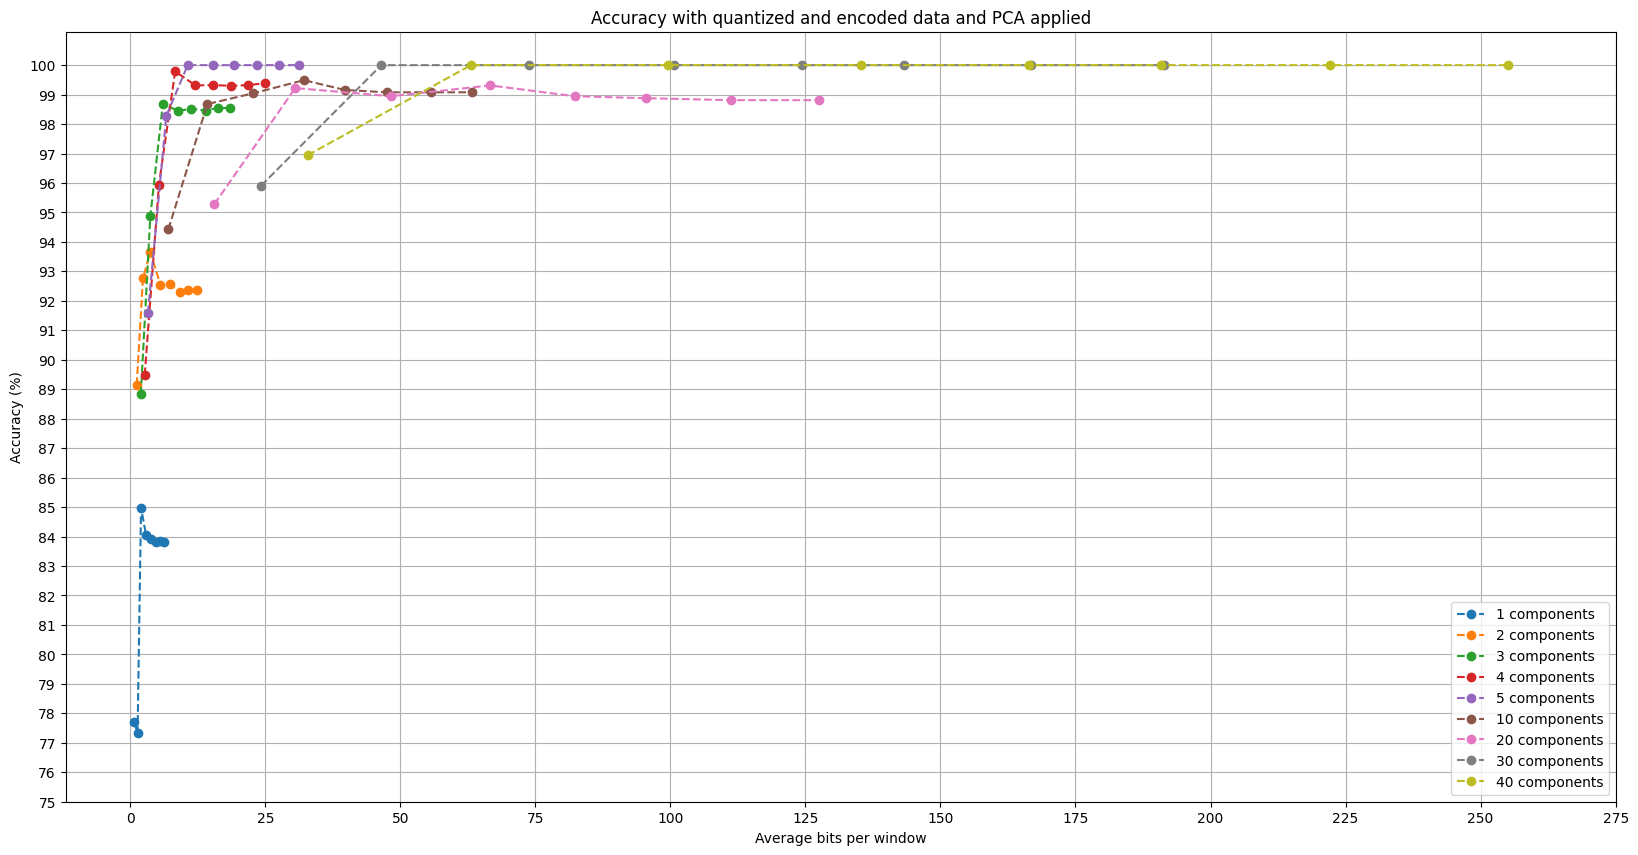

In [30]:
df_accuracy = pd.read_csv('results_csv/DEFAULT/results.csv')
df_bits = pd.read_csv('results_csv/DEFAULT/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]
components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

df_acc_bit['accuracy'] = df_acc_bit['accuracy'].clip(upper=0.56) * 100
accuracy_loss = 100 - (56 - df_acc_bit['accuracy']) 
df_acc_bit['accuracy_loss'] = accuracy_loss

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['ENC_win_bits'], target_data['accuracy_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Accuracy with quantized and encoded data and PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 300, 25))
plt.ylabel('Accuracy (%)')
plt.yticks(np.arange(75, 101, 1))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/accuracy_bit_Encoded[BxW].png'))
plt.show()

In [ ]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]

df_accuracy = pd.read_csv('results_csv/DEFAULT/results.csv')
df_bits = pd.read_csv('results_csv/DEFAULT/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

#components = [1, 2, 3, 4, 5, 10, 20, 30, 40]
df_acc_bit = df_acc_bit[df_acc_bit['num_components'].isin(components)]

plt.figure(figsize=(20, 10))
for lvl in df_acc_bit['num_levels'].unique():
    target_data = df_acc_bit[df_acc_bit['num_levels'] == lvl]

    original_bits = target_data['QT_win_bits']
    huffman_bits = target_data['ENC_win_bits']
    #original_bits = target_data['total_QT_bits']
    #huffman_bits = target_data['total_ENC_bits']
    

    saved_space_percentage = [(orig - huff) / orig * 100 for orig, huff in zip(original_bits, huffman_bits)]
    # Plotting
    plt.plot(components, saved_space_percentage, marker='o', linestyle='--', label=f'{lvl} levels')
plt.xlabel('Number of components')
plt.xticks(components)
plt.ylabel('Saved Space (%)')
plt.title('Average saved space percentage per window on encoded data versus non-encoded data (quantized data with PCA applied)')
plt.grid(True)
plt.legend()
#plt.savefig(os.path.join('results_graphs/saved_space_percentage_[enc-!enc].png'))
# Show the plot
plt.show()


## PCA ONLY

In [110]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

In [ ]:
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)
filename = f'single_antenna_{antenna}'

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/PCA_ONLY/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, saveGraph=True, plotGraph=True)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    #Reconstruct the data
    df_train_reconstructed = reconstruct_data(df_train_reduced, pca, csi_subcarriers)
    df_train_reconstructed = df_train_reconstructed.to_numpy()
    reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
    train_data.csi = reconstructed_train_data

    df_test_reconstructed = reconstruct_data(df_test_reduced, pca, csi_subcarriers)
    df_test_reconstructed = df_test_reconstructed.to_numpy()
    reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
    test_data.csi = reconstructed_test_data

    vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()
    
    print("Encoding train data...")
    z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
    
    print("Encoding test data...")
    z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

    train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
    os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
    test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
    os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
    print("Saving data...")
    with open(train_dump_dir, 'wb') as f:
        pickle.dump([z_data_train, z_labels_train], f)
    with open(test_dump_dir, 'wb') as f:
        pickle.dump([z_data_test, z_labels_test], f)

print("Done")

In [ ]:
filename = f'single_antenna_{antenna}'
results = []

for num_components in components:
    directory = f'./dumps/PCA_ONLY/{num_components}_components'

    print(f"-------------- {num_components} components --------------")
    train_dump_dir = './dumps/single_antenna_0.pkl'
    test_dump_dir = os.path.join(directory, f'test/{filename}_test.pkl')

    # Test model
    accuracy = results_test(train_dump_dir, test_dump_dir, num_components, default=True)
    results.append(
        {
            "num_components": num_components,
            "accuracy": accuracy
        })
        
"""results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/PCA_ONLY_results.csv', index=False)"""

#### Graphs PCA only

In [ ]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
bit_results = []

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/PCA_ONLY/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_bits, PCA_win_bits,total_PCA_bits = bits_needed(df_test_reduced)
    print(f"Bits needed: {PCA_bits} bits")
    print(f"AvgBits needed per window: {PCA_win_bits} bits")
    print(f"Total Bits needed: {total_PCA_bits} bits")

    #Reconstruct the data
    df_test_reconstructed = reconstruct_data(df_test_reduced, pca, csi_subcarriers)
    print (f"DF_RECONSTRUCTED")
    REC_bits, REC_win_bits, total_REC_bits = bits_needed(df_test_reconstructed)
    print(f"Bits needed: {REC_bits} bits")
    print(f"AvgBits needed per window: {REC_win_bits} bits")
    print(f"Total Bits needed: {total_REC_bits} bits")
    
    df_test_reconstructed = df_test_reconstructed.to_numpy()
    reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
    test_data.csi = reconstructed_test_data

    bit_results.append({
        'num_components': num_components,
        'PCA_bits': PCA_bits,
        'REC_bits': REC_bits,
        'PCA_win_bits': PCA_win_bits,
        'REC_win_bits': REC_win_bits,
        'total_PCA_bits': total_PCA_bits,
        'total_REC_bits': total_REC_bits
    })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/PCA_ONLY_bit_results_single_antenna_{antenna}.csv', index=False)

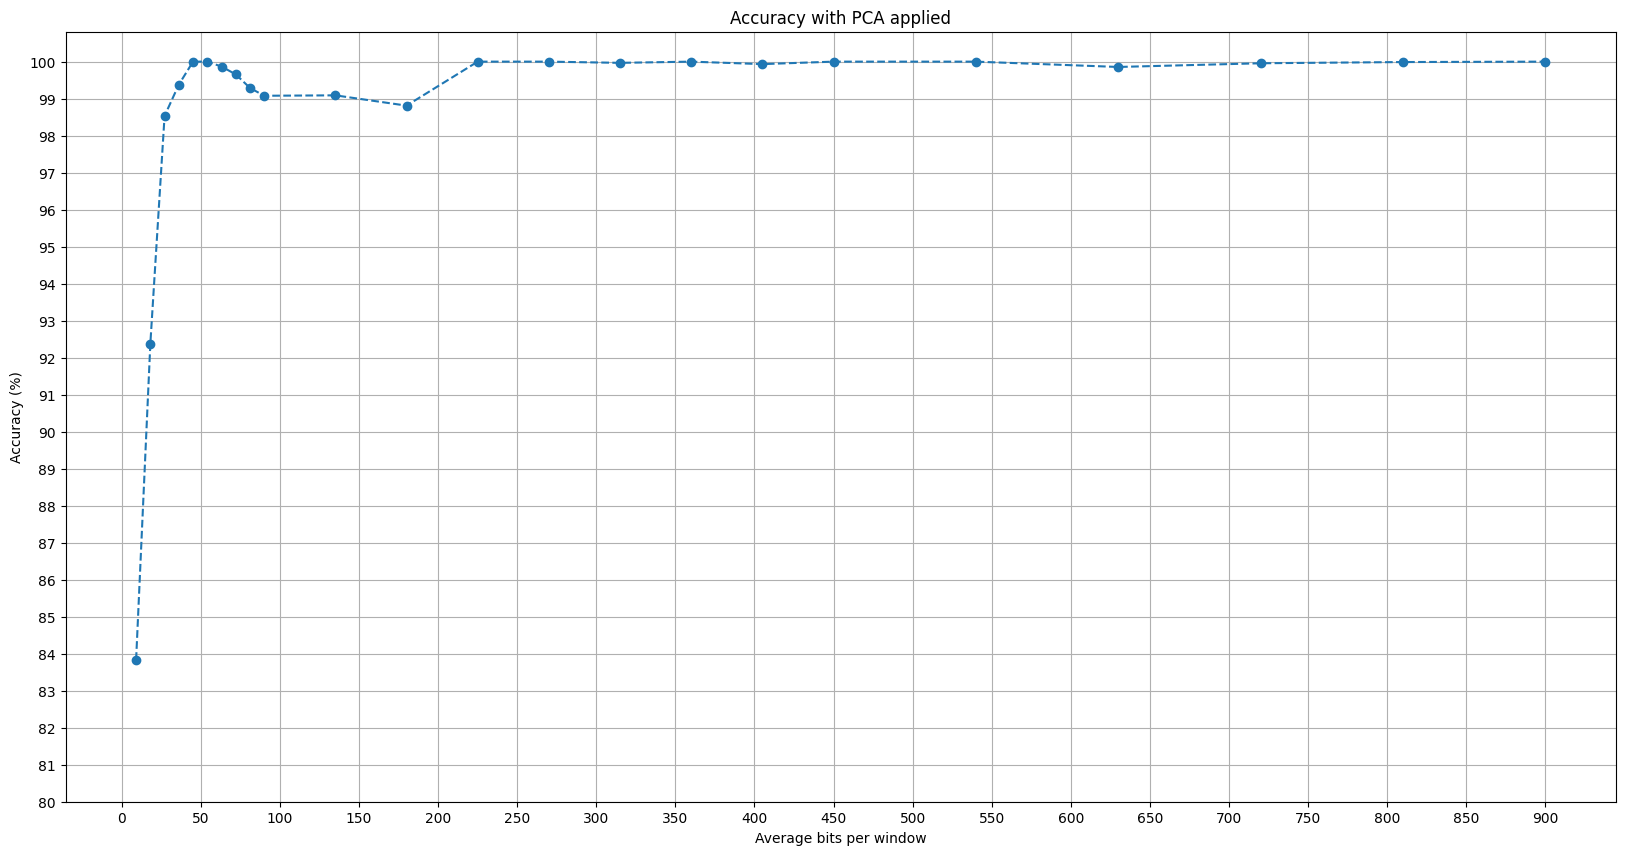

In [29]:
df_accuracy = pd.read_csv('results_csv/DEFAULT/PCA_ONLY_results.csv')
df_bits = pd.read_csv('results_csv/DEFAULT/PCA_ONLY_bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components'])

df_acc_bit['accuracy'] = df_acc_bit['accuracy'].clip(upper=0.56) * 100
accuracy_loss = 100 - (56 - df_acc_bit['accuracy']) 
df_acc_bit['accuracy_loss'] = accuracy_loss

plt.figure(figsize=(20, 10))
plt.plot(df_acc_bit['PCA_win_bits'], df_acc_bit['accuracy_loss'], marker='o', linestyle='--')
#plt.axhline(y=0.56, color="r", linestyle=":", label="Max accuracy no PCA")
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
plt.title('Accuracy with PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 950, 50))
plt.ylabel('Accuracy (%)')
plt.yticks(np.arange(80, 101, 1))
plt.grid()
plt.savefig(os.path.join('results_graphs/accuracy_bit_PCA-Only[BxW].png'))
plt.show()

---

# New Runs

## Functions

In [48]:
base_directory = './results/NEW'
os.makedirs(base_directory, exist_ok=True)

In [49]:
class Sampling(tf_keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_csi_encoder(input_shape, latent_dim):
    encoder_inputs = tf_keras.Input(shape=input_shape)
    x = tf_keras.layers.Conv2D(32, (5, 8), activation='relu', strides=(5, 8), padding='valid')(encoder_inputs)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.Conv2D(64, (5, 8), activation='relu', strides=(5, 8), padding='valid')(x)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.Conv2D(128, (2, 4), activation='relu', strides=(2, 4), padding='valid')(x)
    x = tf_keras.layers.Flatten()(x)
    x = tf_keras.layers.Dense(64, activation='relu')(x)
    x = tf_keras.layers.Dropout(0.3)(x)  # Dropout added to regularize

    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    return tf_keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')


def create_csi_decoder(input_shape, latent_dim, out_filter):
    decoder_inputs = tf_keras.Input(shape=(latent_dim,))
    x = tf_keras.layers.Dense(math.prod(input_shape), activation='relu')(decoder_inputs)
    x = tf_keras.layers.Reshape(input_shape)(x)
    x = tf_keras.layers.Conv2DTranspose(128, (2, 4), activation='relu', strides=(2, 4), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(64, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    decoder_outputs = tf_keras.layers.Conv2DTranspose(out_filter, out_filter, activation='sigmoid', padding='same')(x)

    return tf_keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [50]:
num_epochs_annealing = 1
num_classes = 5

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = 5):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def load_edl_experiment(name):
    keras.models.load_model(name)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test (train_dir, test_dir, num_components=0, num_levels=0, default=False):
    X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dir)
    X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dir, scaler)
    if default:
        model_directory = os.path.join(base_directory, f'0_components/models/0components_0lvls_Keras_Model.keras')
    else:
        model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    
    mlp_edl = keras.models.load_model(model_directory, compile=False)
    mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(tf.argmax(mlp_edl.predict(X_test), axis=1))

    print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))
    accuracy = accuracy_score(y_test, y_predictions_edl)

    cm = confusion_matrix(y_test, y_predictions_edl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")
    CM_directory = os.path.join(base_directory, f'{num_components}_components/CMs/{num_components}components_{num_levels}lvls_ConfusionMatrix.png')
    os.makedirs(os.path.dirname(CM_directory), exist_ok=True)
    cmdisp.figure_.savefig(CM_directory, bbox_inches='tight')

    return round(accuracy, 5)

In [24]:
def run_edl_experiment(name, _X_train, _y_train_dummy, num_components=0, num_levels=0, X_val=None, y_val_dummy=None):

    model_edl = None
    num_classes = 5
    
    if name == "Delayed-Fusing":
        num_epochs_annealing = 3
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(16,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5, activation='softplus'))

    elif name == "Early-Fusing":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.001
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    elif name == "Early-Fusing3":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    else:
        
        num_epochs_annealing = 22
        batch_size = 64
        lr = 0.001
        epochs = 100
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Input(shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
        model_edl.add(tf.keras.layers.Dropout(0.4))
        model_edl.add(tf.keras.layers.Dense(64, activation='relu'))
        model_edl.add(tf.keras.layers.Dropout(0.4))
        model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(5, activation='softplus'))
		
        """
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 100
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.GlorotUniform(seed=random_state), input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.GlorotUniform(seed=random_state)))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))"""
		

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[early_stopping_cb, reduce_lr_cb],
      validation_data=(X_val, y_val_dummy),
      shuffle=False)

    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    os.makedirs(os.path.dirname(model_directory), exist_ok=True)
    model_edl.save(model_directory)


## Training

In [45]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]

In [37]:
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

folder_name = f'models/new_single_antenna_{antenna}'
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

In [ ]:
results = []

print(f"-------------- 0 components --------------")
directory = './dumps/NEW/0_components'
os.makedirs(directory, exist_ok=True)

filename = f'0lvls_single_antenna_{antenna}'

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()

print("Encoding train data...")
z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)

print("Encoding test data...")
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
with open(train_dump_dir, 'wb') as f:
    pickle.dump([z_data_train, z_labels_train], f)
with open(test_dump_dir, 'wb') as f:
    pickle.dump([z_data_test, z_labels_test], f)

In [ ]:
directory = './dumps/NEW/0_components'
filename = f'0lvls_single_antenna_{antenna}'

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
results = []

print("-------------- Training and testing DL model --------------")
X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler=scaler)

name = "No-Fused-1"
run_edl_experiment(name, X_train, y_train_dummy)

# Test model
accuracy = results_test(train_dump_dir, test_dump_dir)

In [ ]:
# Test model
directory = './dumps/NEW/0_components'
filename = f'0lvls_single_antenna_{antenna}'
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
accuracy = results_test(train_dump_dir, test_dump_dir, default=True)

## VAE Output Quantized

In [25]:
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

In [ ]:
#Use the VAE to process CSI data
z_data = np.zeros([0, 4])
z_labels = np.zeros([0])

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()

z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

In [ ]:
directory = f'./dumps/NEW/VAE_QNTZD/0_components'
os.makedirs(directory, exist_ok=True)
bit_results = []
levels = [2**i for i in range(1, 9)]

df_z_data_train = pd.DataFrame(z_data_train, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
df_z_data_test = pd.DataFrame(z_data_test, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])

for lvl in levels:
    print(f"-------------- {lvl} lvls --------------")
    df_train_quantized = apply_quantization(df_z_data_train, lvl)
    df_test_quantized = apply_quantization(df_z_data_test, lvl)
    print (f"DF_QUANTIZED")
    QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_test_quantized, lvl)
    print(f"Bits needed: {QT_bits} bits")
    print(f"AvgBits needed per window: {QT_win_bits} bits")
    print(f"Total Bits needed: {total_QT_bits} bits")

    z_data_train = df_train_quantized.to_numpy()
    z_data_test = df_test_quantized.to_numpy()

    sub_dir=os.path.join(directory, f'training/{lvl}lvls_single_antenna_{antenna}.pkl')
    os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
    with open(sub_dir, 'wb') as f:
       pickle.dump([z_data_train, z_labels_train], f)

    sub_dir=os.path.join(directory, f'test/{lvl}lvls_single_antenna_{antenna}_test.pkl')
    os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
    with open(sub_dir, 'wb') as f:
       pickle.dump([z_data_test, z_labels_test], f)

    bit_results.append({
            'num_levels': lvl,
            'QT_bits': QT_bits,
            'QT_win_bits': QT_win_bits,
            'total_QT_bits': total_QT_bits,
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/NEW/VAE_bit_results_single_antenna_{antenna}.csv', index=False)

In [ ]:
directory = f'./dumps/NEW/VAE_QNTZD/0_components'
results = []
levels = [2**i for i in range(1, 9)]
for num_levels in levels:  
    print(f"-------------- {num_levels} lvls --------------")
    filename = f'{num_levels}lvls_single_antenna_{antenna}'
    train_dump_dir = './dumps/NEW/single_antenna_0.pkl'
    test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

    # Test model
    accuracy = results_test(train_dump_dir, test_dump_dir, num_levels=num_levels, default=True)
    results.append(
        {
            "num_levels": num_levels,
            "accuracy": accuracy
        })
        
results_df = pd.DataFrame(results)
results_df.to_csv('results_csv/NEW/VAE_results.csv', index=False)

### Graphs

In [ ]:
df_VAE_accuracy = pd.read_csv('results_csv/NEW/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/NEW/VAE_bit_results_single_antenna_0.csv')

df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE', linewidth=3)
plt.title('Accuracy and Bits Comparison (quantized data post VAE)')
plt.axhline(y=0.70, color="r", linestyle=":", label="max accuracy")
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/NEW/accuracy_bit_POST_VAE[BxW].png'))
plt.show()

## PCA Only

In [ ]:
filename = f'single_antenna_{antenna}'
results = []

for num_components in components:
    directory = f'./dumps/NEW/PCA_ONLY/{num_components}_components'

    print(f"-------------- {num_components} components --------------")
    train_dump_dir = './dumps/NEW/single_antenna_0.pkl'
    test_dump_dir = os.path.join(directory, f'test/{filename}_test.pkl')

    # Test model
    accuracy = results_test(train_dump_dir, test_dump_dir, num_components, default=True)
    results.append(
        {
            "num_components": num_components,
            "accuracy": accuracy
        })

results_df = pd.DataFrame(results)
results_df.to_csv('results_csv/NEW/PCA_ONLY_results.csv', index=False)

### Graphs

In [ ]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
bit_results = []

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/NEW/PCA_ONLY/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_bits, PCA_win_bits,total_PCA_bits = bits_needed(df_test_reduced)
    print(f"Bits needed: {PCA_bits} bits")
    print(f"AvgBits needed per window: {PCA_win_bits} bits")
    print(f"Total Bits needed: {total_PCA_bits} bits")

    #Reconstruct the data
    df_test_reconstructed = reconstruct_data(df_test_reduced, pca, csi_subcarriers)
    print (f"DF_RECONSTRUCTED")
    REC_bits, REC_win_bits, total_REC_bits = bits_needed(df_test_reconstructed)
    print(f"Bits needed: {REC_bits} bits")
    print(f"AvgBits needed per window: {REC_win_bits} bits")
    print(f"Total Bits needed: {total_REC_bits} bits")
    
    df_test_reconstructed = df_test_reconstructed.to_numpy()
    reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
    test_data.csi = reconstructed_test_data

    bit_results.append({
        'num_components': num_components,
        'PCA_bits': PCA_bits,
        'REC_bits': REC_bits,
        'PCA_win_bits': PCA_win_bits,
        'REC_win_bits': REC_win_bits,
        'total_PCA_bits': total_PCA_bits,
        'total_REC_bits': total_REC_bits
    })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/NEW/PCA_ONLY_bit_results_single_antenna_{antenna}.csv', index=False)

In [ ]:
df_accuracy = pd.read_csv('results_csv/NEW/PCA_ONLY_results.csv')
df_bits = pd.read_csv('results_csv/NEW/PCA_ONLY_bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components'])

df_accuracy = pd.read_csv('results_csv/PCA_ONLY_results.csv')
df_bits = pd.read_csv('results_csv/PCA_ONLY_bit_results_single_antenna_0.csv')
df_acc_bit2 = pd.merge(df_accuracy, df_bits, on=['num_components'])

plt.figure(figsize=(20, 10))
plt.plot(df_acc_bit['PCA_win_bits'], df_acc_bit['accuracy'], marker='o', linestyle='--', label='New VAE')
plt.plot(df_acc_bit2['PCA_win_bits'], df_acc_bit2['accuracy'], marker='o', linestyle='--', label='Old VAE')
plt.axhline(y=0.70, color="r", linestyle=":", label="(New) Max accuracy no PCA ")
plt.axhline(y=0.56, color="g", linestyle=":", label="(Old) Max accuracy no PCA")
plt.title('Accuracy and Bits Comparison (Per PCA Component: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100])')
plt.xlabel('avg bits per window')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(os.path.join('results_graphs/NEW/VAEs_comparison_PCA_ONLY.png'))
plt.show()

## Comprehensive run

In [ ]:
results = []
for num_components in components:
    directory = f'./dumps/NEW/{num_components}_components'
    for num_levels in levels:  
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}lvls_single_antenna_{antenna}'
        train_dump_dir = './dumps/NEW/single_antenna_0.pkl'
        test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

        # Test model
        accuracy = results_test(train_dump_dir, test_dump_dir, num_components, num_levels, default=True)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "accuracy": accuracy
            })
        

results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/NEW/results.csv', index=False)

### Graphs

In [ ]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]
bit_results = []

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/NEW/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_bits, PCA_win_bits,total_PCA_bits = bits_needed(df_test_reduced)
    print(f"Bits needed: {PCA_bits} bits")
    print(f"AvgBits needed per window: {PCA_win_bits} bits")
    print(f"Total Bits needed: {total_PCA_bits} bits")

    for num_levels in levels:
        print(f"-------------- {num_components} components {num_levels} lvls --------------")
        #Quantize the data
        df_test_quantized = apply_quantization(df_test_reduced, num_levels)
        print (f"DF_QUANTIZED")
        QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_test_quantized, num_levels)
        print(f"Bits needed: {QT_bits} bits")
        print(f"AvgBits needed per window: {QT_win_bits} bits")
        print(f"Total Bits needed: {total_QT_bits} bits")

        #Reconstruct the data
        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        print (f"DF_RECONSTRUCTED")
        REC_bits, REC_win_bits, total_REC_bits = bits_needed(df_test_reconstructed)
        print(f"Bits needed: {REC_bits} bits")
        print(f"AvgBits needed per window: {REC_win_bits} bits")
        print(f"Total Bits needed: {total_REC_bits} bits")
        
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
        test_data.csi = reconstructed_test_data

        bit_results.append({
            'num_components': num_components,
            'num_levels': num_levels,
            'PCA_bits': PCA_bits,
            'QT_bits': QT_bits,
            'REC_bits': REC_bits,
            'PCA_win_bits': PCA_win_bits,
            'QT_win_bits': QT_win_bits,
            'REC_win_bits': REC_win_bits,
            'total_PCA_bits': total_PCA_bits,
            'total_QT_bits': total_QT_bits,
            'total_REC_bits': total_REC_bits
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/NEW/bit_results_single_antenna_{antenna}.csv', index=False)

In [ ]:
df_accuracy = pd.read_csv('results_csv/NEW/results.csv')
df_bits = pd.read_csv('results_csv/NEW/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

"""df_VAE_accuracy = pd.read_csv('results_csv/NEW/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/NEW/VAE_bit_results_single_antenna_0.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])"""

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
#plt.plot(df_VAE_acc_bit['QT_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE', linewidth=3)
plt.axhline(y=0.70, color="r", linestyle=":", label="max accuracy no PCA")
plt.title('Accuracy and Bits Comparison (PCA and Quantized data)')
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.savefig(os.path.join('results_graphs/NEW/accuracy_bit[BxS][filtered].png'))
plt.show()

In [ ]:
df_accuracy = pd.read_csv('results_csv/NEW/results.csv')
df_bits = pd.read_csv('results_csv/NEW/bit_results_single_antenna_0.csv')
df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])

df_VAE_accuracy = pd.read_csv('results_csv/NEW/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/NEW/VAE_bit_results_single_antenna_0.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]


plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_win_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_acc_bit['QT_win_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE', linewidth=3)
plt.axhline(y=0.70, color="r", linestyle=":", label="max accuracy no PCA")
plt.title('Accuracy and Bits Comparison (PCA and Quantized data)')
plt.xlabel('Average bits per window')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(os.path.join('results_graphs/NEW/accuracy_bit[BxW][1-25].png'))
plt.show()

## w/ Validation

In [25]:
base_directory = './results/TESTING/DEFAULT'
os.makedirs(base_directory, exist_ok=True)

In [26]:
components = list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10))
levels = [2**i for i in range(1, 9)]

In [ ]:
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

#folder_name = f'models/new_single_antenna_{antenna}'
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]

train_data, validation_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS, verbose=True)

In [ ]:
results = []

print(f"-------------- 0 components --------------")
directory = './dumps/TESTING/DEFAULT/0_components'
os.makedirs(directory, exist_ok=True)

filename = f'0lvls_single_antenna_{antenna}'

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()

print("Encoding train data...")
z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)

print("Encoding validation data...")
z_data_validation, z_labels_validation = apply_vae_encoder(vae, validation_data)

print("Encoding test data...")
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
validation_data_dir=os.path.join(directory, f'validation/{filename}_validation.pkl')
os.makedirs(os.path.dirname(validation_data_dir), exist_ok=True)
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
with open(train_dump_dir, 'wb') as f:
    pickle.dump([z_data_train, z_labels_train], f)
with open(validation_data_dir, 'wb') as f:
    pickle.dump([z_data_validation, z_labels_validation], f)
with open(test_dump_dir, 'wb') as f:
    pickle.dump([z_data_test, z_labels_test], f)

In [ ]:
directory = './dumps/TESTING/DEFAULT/0_components'
filename = f'0lvls_single_antenna_{antenna}'

train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
validation_dump_dir=os.path.join(directory, f'validation/{filename}_validation.pkl')
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
results = []

print("-------------- Training and testing DL model --------------")
X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
X_validation, y_validation, y_validation_dummy, _, fcolumns = load_experiment(validation_dump_dir, scaler)
X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler)

name = "No-Fused-1"
run_edl_experiment(name, X_train, y_train_dummy, X_val=X_validation, y_val_dummy=y_validation_dummy)

# Test model
accuracy = results_test(train_dump_dir, test_dump_dir)

In [ ]:
# Test model without validation data
base_directory = './results/DEFAULT'
directory = './dumps/DEFAULT/0_components'
filename = f'0lvls_single_antenna_{antenna}'
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
accuracy = results_test(train_dump_dir, test_dump_dir, default=True)